In [ ]:
!git clone https://github.com/aplbrain/grandiso-networkx.git

Cloning into 'grandiso-networkx'...
remote: Enumerating objects: 413, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 413 (delta 78), reused 50 (delta 50), pack-reused 292
Receiving objects: 100% (413/413), 177.89 KiB | 1.41 MiB/s, done.
Resolving deltas: 100% (201/201), done.


In [ ]:
import sys
sys.path.append('grandiso-networkx')

In [ ]:
import networkx as nx
import pandas as pd
from grandiso import find_motifs
import matplotlib.pyplot as plt
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [ ]:
# Load data and view the columns
all_data = pd.read_csv("./BIOGRID-PROJECT-glioblastoma_project-INTERACTIONS-4.4.220.tab3.txt",sep='\t')
print(all_data.columns)
all_data.shape

<ipython-input-6-29becb46f616>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv("./BIOGRID-PROJECT-glioblastoma_project-INTERACTIONS-4.4.220.tab3.txt",sep='\t')


Index(['#BioGRID Interaction ID', 'Entrez Gene Interactor A',
       'Entrez Gene Interactor B', 'BioGRID ID Interactor A',
       'BioGRID ID Interactor B', 'Systematic Name Interactor A',
       'Systematic Name Interactor B', 'Official Symbol Interactor A',
       'Official Symbol Interactor B', 'Synonyms Interactor A',
       'Synonyms Interactor B', 'Experimental System',
       'Experimental System Type', 'Author', 'Publication Source',
       'Organism ID Interactor A', 'Organism ID Interactor B', 'Throughput',
       'Score', 'Modification', 'Qualifications', 'Tags', 'Source Database',
       'SWISS-PROT Accessions Interactor A', 'TREMBL Accessions Interactor A',
       'REFSEQ Accessions Interactor A', 'SWISS-PROT Accessions Interactor B',
       'TREMBL Accessions Interactor B', 'REFSEQ Accessions Interactor B',
       'Ontology Term IDs', 'Ontology Term Names', 'Ontology Term Categories',
       'Ontology Term Qualifier IDs', 'Ontology Term Qualifier Names',
       'Ontology

(49087, 37)

In [ ]:
# Filter out human interactions from the rest of the data
human_ppi = all_data[(all_data['Organism Name Interactor A'] == "Homo sapiens") 
                   & (all_data['Organism Name Interactor B'] == "Homo sapiens")]

print(f"glioblastoma human interactions has {human_ppi.shape[0]} rows")

glioblastoma human interactions has 48011 rows


In [ ]:
# Create a UNDIRECTED graph 
Graphtype = nx.Graph()
g_glio_human_undir = nx.from_pandas_edgelist(
    human_ppi, source="Official Symbol Interactor A", target='Official Symbol Interactor B', create_using = Graphtype, edge_attr=['Experimental System'])

In [ ]:
# Get Number of Nodes for our full graph.
g_glio_human_undir.number_of_nodes()

10358

In [ ]:
# Prints out the degree of every node in the network and finds the node with the maximum degree (just to see)
degrees = nx.degree(g_glio_human_undir)

max_degree = max(degrees, key=lambda x: x[1])
print(f"The maximally-connected node is {max_degree[0]} with {max_degree[1]} edges")

The maximally-connected node is PARK2 with 3410 edges


In [ ]:
# Calculate avg degree of all the nodes in our data
tot = 0
for node, degree in degrees:
    tot+=degree
tot/len(degrees)

5.871403745896892

In [ ]:
def create_node_neighbor_ls_dict(g):
    '''
    g: input networkx graph object

    Creates a dict with nodes as keys
    and lists of neighbors of the node as values .

    Returns the created dict.
    '''
    node_neighbor_dict={}

    for node in g.nodes():
        node_neighbor_dict[node] = list(g.neighbors(node))

    return node_neighbor_dict

def find_nodes_with_neighbors(g):
    '''
    g: input networkx graph object
    returns list of nodes with neighbors
    '''
    # find nodes only with neighbors
    node_neighbor_dict = create_node_neighbor_ls_dict(g)

    new_node_neighbor_dict = {}
    for k,v in node_neighbor_dict.items():
        if len(v) != 0:
            new_node_neighbor_dict[k] = v
            
    nodes_with_neighbors_ls = list(new_node_neighbor_dict.keys())
    
    return nodes_with_neighbors_ls

def select_source_node(node_neighbor_dict, bag_of_nodes_ls, final_set_of_nodes):
    '''
    selects source node from graph (node_neighbor_dict)
    returns bag_of_nodes_ls (where new nodes will be picked)
    and  final_set_of_nodes (final subset of nodes)
    '''
    # empty out these two lists just in case they are not empty
    final_set_of_nodes.clear()
    bag_of_nodes_ls.clear()

    # choose a source node and its neighbors
    source_node = random.choice(list(node_neighbor_dict.keys()))
    neighbors_ls = node_neighbor_dict[source_node]
    
    # extend bag_of_nodes_ls with list of neighbors of the random node
    bag_of_nodes_ls.extend(neighbors_ls)

    # add source node to final set
    final_set_of_nodes.append(source_node)

    return bag_of_nodes_ls, final_set_of_nodes
    
def select_rand_node_with_neighbors_from_bag_of_nodes(node_neighbor_dict, bag_of_nodes_ls, final_set_of_nodes, n_nodes_sampled_so_far):
    '''
    Return randomly selected node from bag_of_nodes_ls 
    and the list of neighbors of that node.
    '''
    n = 0
    random_node = bag_of_nodes_ls.pop(random.randrange(len(bag_of_nodes_ls)))

    while True:
        # take care of redundancy
        if random_node in (node_neighbor_dict.keys()) and random_node not in final_set_of_nodes:
            return random_node, node_neighbor_dict[random_node]
        else:
            if len(bag_of_nodes_ls) == 0:
                # print('bag of nodes empty'). # Often, selected nodes run out of neighbors
                return None
            random_node = bag_of_nodes_ls.pop(random.randrange(len(bag_of_nodes_ls)))
            
def rand_connected_component_with_size_n(g, n):
    '''
    randomly selects nodes using random module
    returns a list of nodes of len n
    '''
    # get complete dict of node : neighbors_list
    node_dict = create_node_neighbor_ls_dict(g)
    nodes_with_neighbors_ls = find_nodes_with_neighbors(g)
   
    #create new dict with only the nodes with neighbors
    node_neighbor_dict={}
    for node in nodes_with_neighbors_ls:
        node_neighbor_dict[node] = node_dict[node]
    
    #potential nodes to be selected
    bag_of_nodes_ls = []
    final_set_of_nodes=[]
    
    for i in range(n): 
        if i==0:
            bag_of_nodes_ls, final_set_of_nodes = select_source_node(node_neighbor_dict, bag_of_nodes_ls, final_set_of_nodes)
        else:
            # now randomly select from bag_of_nodes_ls 
            output = select_rand_node_with_neighbors_from_bag_of_nodes(node_neighbor_dict, 
                                                                       bag_of_nodes_ls,
                                                                       final_set_of_nodes, 
                                                                       i)
            if output == None:
                return None
            else:
                rand_node, neighbors_ls  = output

            # extend bag_of_nodes_ls with new potential nodes to be added to the subgraph
            bag_of_nodes_ls.extend(neighbors_ls)

            # add a new random node from the bag of nodes to final set
            final_set_of_nodes.append(rand_node)
    
    subgraph = g.subgraph(final_set_of_nodes)
    return subgraph

def create_rand_subgraph_of_size_n_by_adding_edges(g, n):
    '''
    wrapper func of rand_connected_component_with_size_n
    to ensure that output subgraph is size n
    '''
    while True:
        out_subgraph = rand_connected_component_with_size_n(g,n)

        if out_subgraph == None:
            continue
        else:
            if isinstance(out_subgraph, nx.classes.graph.Graph) and len(out_subgraph.nodes()) == n:
                return out_subgraph


50


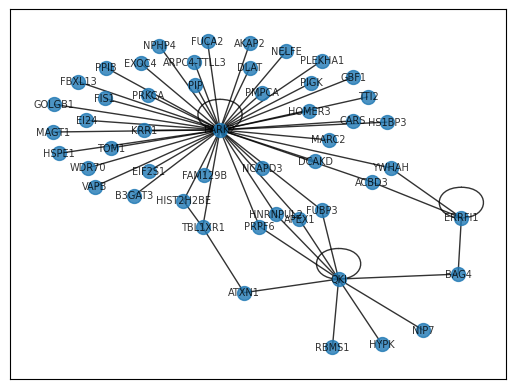

In [ ]:
# Testing Method 1: Create subgraph by adding random neighbors
subgraph = create_rand_subgraph_of_size_n_by_adding_edges(g_glio_human_undir, 50)
# print(isinstance(subgraph,nx.classes.graph.Graph))
print(len(subgraph.nodes()))
nx.draw_networkx(subgraph, node_size=100,font_size=7, alpha=0.8)

In [ ]:
def make_bfs_tree_from_graph(g, nodes_with_neighbors_ls, depth):
    '''
    g: graph
    nodes_with_neighbors_ls: nodes from graph g with neighbors
    depth: depth of dfs search

    *Increaseing depth can increase number of nodes by a lot!
    Check number of nodes in the generated tree
    '''
    # randomly select a source node for BFS
    source = random.choice(nodes_with_neighbors_ls)

    # build bfs tree
    bfs_t = nx.bfs_tree(g, source=source, depth_limit=depth)

    return bfs_t

    
def prune(bfs_t, n):
    '''
    prune n random leaf nodes 
    from bfs tree
    '''
    # get initial leaf nodes from the tree
    leaf_nodes_ls = [n for n in bfs_t if bfs_t.out_degree(n) == 0]

    while True:
        # check if the number of all the leaves are smaller than number of nodes to be pruned
        if len(leaf_nodes_ls) < n:
            # print('len(leaf_nodes_ls): ',len(leaf_nodes_ls))
            bfs_t.remove_nodes_from(leaf_nodes_ls)

            # update n, which is number of nodes to prune
            n = n - len(leaf_nodes_ls)
            leaf_nodes_ls = [n for n in bfs_t if bfs_t.out_degree(n) == 0]

        else:
            if n <= 0:
                # often goes to negative when it shouldn't.
                break

            leaves_to_prune_ls = random.sample(leaf_nodes_ls, n)

            bfs_t.remove_nodes_from(leaves_to_prune_ls)
            n = n - len(leaves_to_prune_ls)

    return bfs_t

def prune_leaves(bfs_t, desired_size = 100):
    '''
    bfs_t: tree (networkx graph obj) to be pruned
    desired_size: desired node size

    returns pruned bfs tree
    '''
    # prune leaves until we have a tree with desired size 
    n_nodes = len(list(bfs_t.nodes()))
    n_leaves_to_prune = n_nodes - desired_size
    
    pruned_bfs_t = prune(bfs_t, n_leaves_to_prune)

    # print('node len after pruning: ', len(list(pruned_bfs_t.nodes())))
    return pruned_bfs_t

def rand_connected_component_with_size_n_using_dfs(g, n, search_depth):
    '''
    returns subgraph of size n

    * no seed in this function => generated graphs are not reproducible
    '''
    nodes_with_neighbors_ls = find_nodes_with_neighbors(g)
    bfs_t = make_bfs_tree_from_graph(g,nodes_with_neighbors_ls, search_depth)
    pruned_bfs_t = prune_leaves(bfs_t, desired_size = n)
    
    # restore all the edges of all the nodes in the tree 
    subgraph_bfs = g.subgraph(list(pruned_bfs_t.nodes()))
    return subgraph_bfs

def create_rand_subgraph_of_size_n_by_pruning_edges(g, n,search_depth):
    '''
    wrapper func of rand_connected_component_with_size_n_using_dfs
    to ensure that output subgraph is size n
    '''
    while True:
        out_subgraph = rand_connected_component_with_size_n_using_dfs(g,n,search_depth)
        
        if isinstance(out_subgraph, nx.classes.graph.Graph) and len(out_subgraph.nodes()) == n:
            return out_subgraph





50


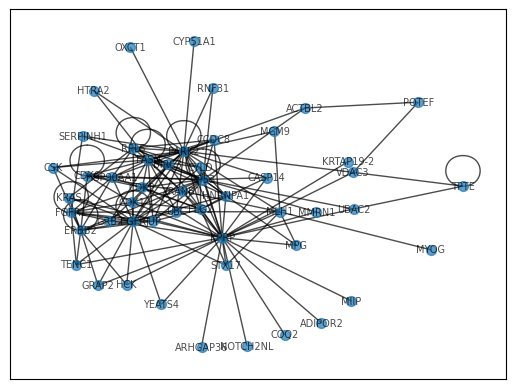

In [ ]:
# Testing Method 2: Create subgraph using BFS and pruning leaves
subgraph_bfs = create_rand_subgraph_of_size_n_by_pruning_edges(g_glio_human_undir, n=50, search_depth=5)
print(len(subgraph_bfs.nodes()))
nx.draw_networkx(subgraph_bfs, node_size=50,font_size=7, alpha=0.7)

In [ ]:
def check_motif_repeat(query, motif_list):
    '''
    This checks if a query motif is found within a list of motifs. 

    Returns true if the motif is NOT present.
    '''
    result = True
    for motif in motif_list:
        if nx.is_isomorphic(motif, query):
            result = False
            break

    return result


def append_edges(query, edge_list):
    '''
    This appends an edge from query into edge_list, 
    only if it wasn't already there.
    '''
    num_edges = len(query)
    for edge in query:
        if edge not in edge_list:
            edge_list.append(edge)
    return edge_list


def calc_percentage_of_edges_covered(subgraph, motif_list):
    '''
    calculate the percentage of edges covered in the motif list.
    Duplicate edges will not be counted.

    returns the percentage of the edges used in motifs

    Note: If 90% or more of the edges are covered, the search is done..
    '''
    subgraph_edges_cnt = len(list(subgraph.edges))

    edges_in_motifs = []
    for motif in motif_list:
        for edge in motif.edges():
            if edge in edges_in_motifs: # account for cases when multiple motifs contain overlapping edges
                continue
            edges_in_motifs.append(edge)
    
    return (len(edges_in_motifs) / subgraph_edges_cnt)*100


def enumerate_subgraphs(graph, edge_percent_coverage=70, simulation_number=500, subgraph_size=100, motif_size=5, dfs_subgraph=False, dfs_motif=False):
    '''
    1. Generate subgraphs (size = subgraph_size) from our graph generated from data. (Reduce search time)
    2. Find motifs in the subgraph (size = motif_size) 
    
    Avoid checking the same motif twice.
    '''
    # Simulate 500 samplings of a subgraph of size 100 from the original network
    simulation_dict = {}  # Store result of each simulation
    for i in range(simulation_number):
        rand_depth_for_bfs = random.randint(2, 8)

        # Create a random subgraph of the network
        if dfs_subgraph:
            # Method 1: Create subgraph using BFS and pruning leaves
            subgraph = create_rand_subgraph_of_size_n_by_pruning_edges(graph, 
                                                                      n = subgraph_size, 
                                                                      search_depth = rand_depth_for_bfs)
        else:
            # Method 2: Create subgraph by adding random neighbors one by one 
            subgraph = create_rand_subgraph_of_size_n_by_adding_edges(graph, 
                                                            n=subgraph_size)
            
        # Lets find motifs in subgraphs. Store motifs and edges already found
        motif_list = []
        edges = []
        motif_count_dict = {}  # store the motif and its count
        num_subgraph_edges = len(subgraph.edges())
        index = 0
        iteration_n = 0
        # terminate loop when all edges in the subgraph have been used in motifs
        while len(edges) != num_subgraph_edges:

            if iteration_n == 800: # break while loop when reach too many iterations
                    print(i,'th simulation')
                    print('% edges covered at 800th iteration: ',calc_percentage_of_edges_covered(subgraph, motif_list))
                    print()
                    break

            if dfs_motif:
                rand_depth_for_bfs = random.randint(1, 4)
                motif = create_rand_subgraph_of_size_n_by_pruning_edges(subgraph, n = motif_size, search_depth = rand_depth_for_bfs)
            else:
                motif = create_rand_subgraph_of_size_n_by_adding_edges(subgraph, n = motif_size)

            # Check if this motif was used before
            is_motif_new = check_motif_repeat(motif, motif_list)
            
            iteration_n+=1
            
            if is_motif_new:
                # If new, keep in motif list
                motif_list.append(motif)
                # Add the unique edges from the motif to edge list
                edges = append_edges(edges, list(motif.edges()) )
                # Count the number of this motif
                matches = find_motifs(motif, subgraph)
                # Store the result with the index of the search
                motif_count_dict[index] = [motif, len(matches), matches]
                
                print("% of edges covered: ",calc_percentage_of_edges_covered(subgraph, motif_list))

                # To visualize new motifs:
                # nx.draw_networkx(motif, node_size=50,font_size=7, alpha=0.7)
                # plt.show()

                # Exit while loop if certain percentage of edges has been covered
                if calc_percentage_of_edges_covered(subgraph, motif_list) > edge_percent_coverage:
                    print('% edges covered at the end: ',calc_percentage_of_edges_covered(subgraph, motif_list))
                    break 
            else:
                continue
            
        simulation_dict[i] = motif_count_dict

    return simulation_dict

In [ ]:
subgraph_size = 30
motif_size = 4
num_simulations = 50

simulation_dict = enumerate_subgraphs(g_glio_human_undir, 
                                      edge_percent_coverage=60, 
                                      simulation_number = num_simulations, 
                                      subgraph_size = subgraph_size, 
                                      motif_size = motif_size, 
                                      dfs_subgraph = True, 
                                      dfs_motif = True)

% of edges covered:  6.172839506172839
% of edges covered:  13.580246913580247
% of edges covered:  19.753086419753085
% of edges covered:  29.629629629629626
% of edges covered:  34.5679012345679
% of edges covered:  38.2716049382716
% of edges covered:  43.20987654320987
% of edges covered:  44.44444444444444
% of edges covered:  46.913580246913575
% of edges covered:  53.086419753086425
% of edges covered:  55.55555555555556
% of edges covered:  56.79012345679012
% of edges covered:  60.49382716049383
% edges covered at the end:  60.49382716049383
% of edges covered:  9.836065573770492
% of edges covered:  19.672131147540984
% of edges covered:  24.59016393442623
% of edges covered:  29.508196721311474
% of edges covered:  34.42622950819672
% of edges covered:  36.0655737704918
% of edges covered:  39.34426229508197
% of edges covered:  42.62295081967213
% of edges covered:  47.540983606557376
% of edges covered:  55.73770491803278
% of edges covered:  57.377049180327866
% of edges 

In [ ]:
# Functions for retrieving motif counts from the simulation results 

def check_motif_repeat2(query, motif_list):
    '''
    This function checks if a query motif is found within a list of motifs. 
    Returns True if the motif is NOT present + idx of that motif
    '''
    result = True
    for idx, motif in enumerate(motif_list):
        if nx.is_isomorphic(motif[0], query):
            result = False
            return result,idx
    return result, -1


def return_list_of_most_freq_motifs(simulation_dict):
    motifs_ls = []

    # iter over all simulations
    for sim_k, sim_v in simulation_dict.items():

        # in each sim, append motifs dict {idx:[motif, len(matches), matches]}'s value
        for motif_k, motif_v in sim_v.items():

            check, idx = check_motif_repeat2(motif_v[0], motifs_ls)
            n_matches = motif_v[1]
            
            # if same motif IS IN motifs_ls
            if check == True: 
                if n_matches != 0:
                    motifs_ls.append(motif_v)  
            else:
                if n_matches != 0:
                    motifs_ls[idx][1]+= n_matches

    # sort based on len(matches) in descending order to find top 3 highest occurring motifs
    sorted_motifs_ls = sorted(motifs_ls, key=lambda motif_info : motif_info[1], reverse=True)

    return sorted_motifs_ls

In [ ]:
motif_freq = return_list_of_most_freq_motifs(simulation_dict)

0th motif's Frequency: 7798


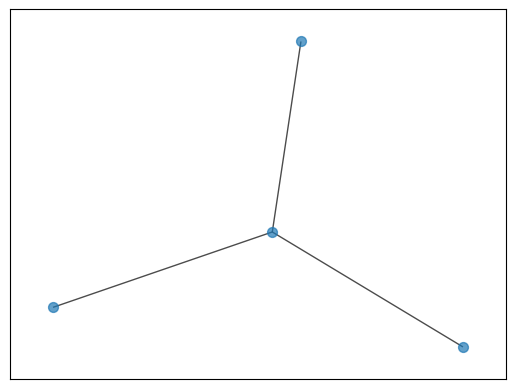

1th motif's Frequency: 630


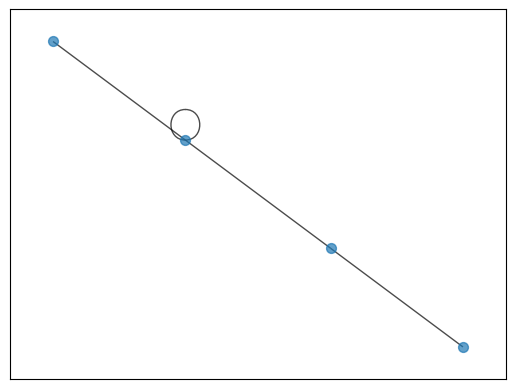

2th motif's Frequency: 306


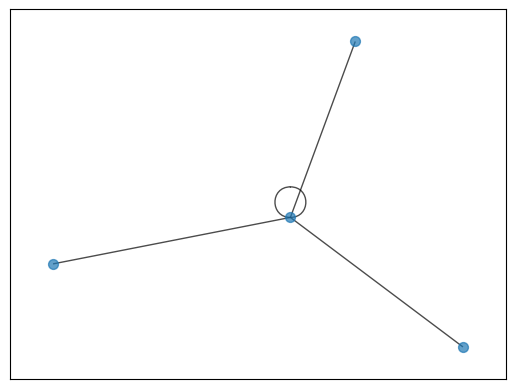

3th motif's Frequency: 171


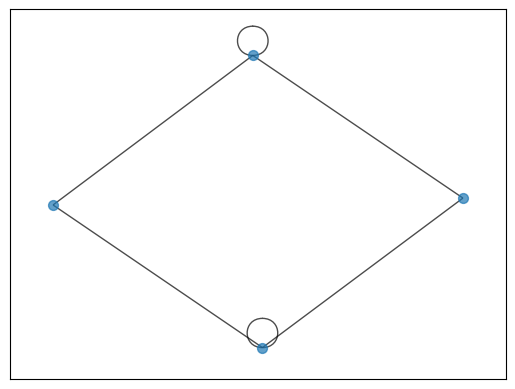

4th motif's Frequency: 50


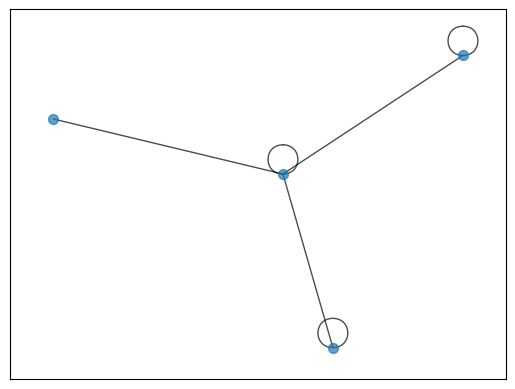

5th motif's Frequency: 33


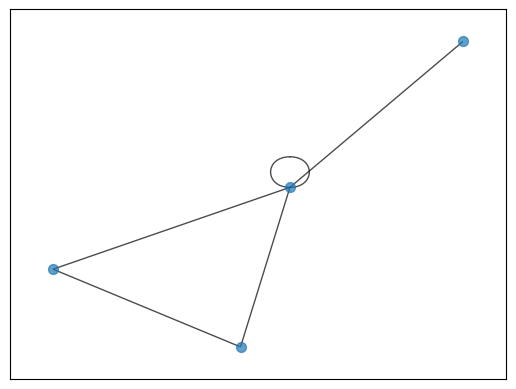

6th motif's Frequency: 28


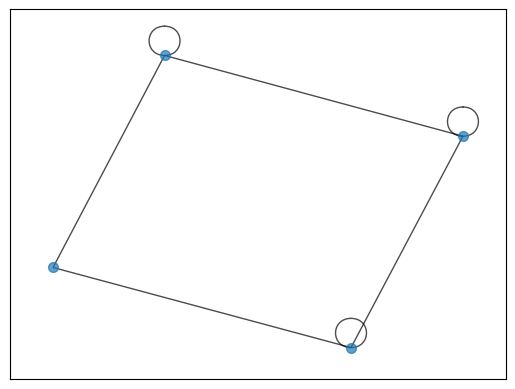

7th motif's Frequency: 25


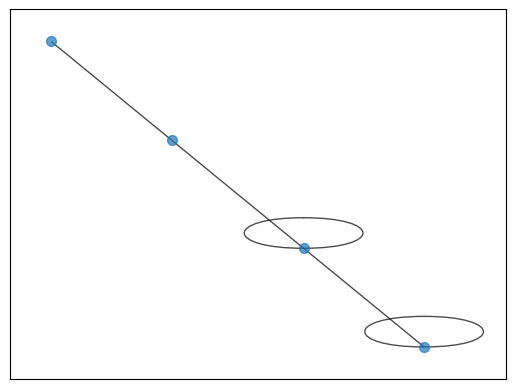

8th motif's Frequency: 10


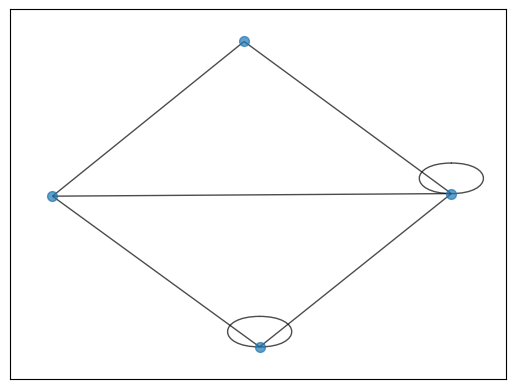

9th motif's Frequency: 10


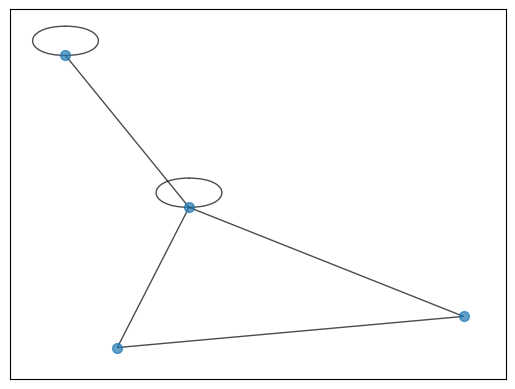

10th motif's Frequency: 8


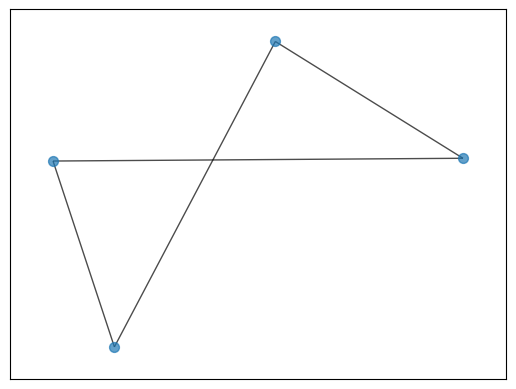

11th motif's Frequency: 8


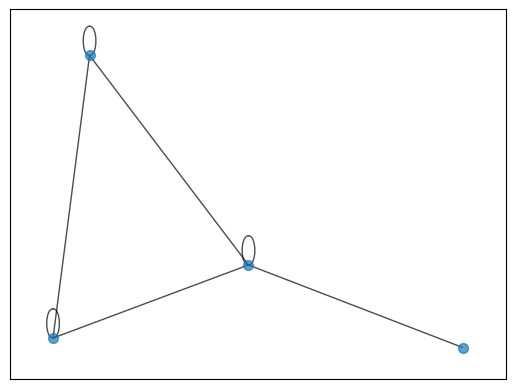

12th motif's Frequency: 7


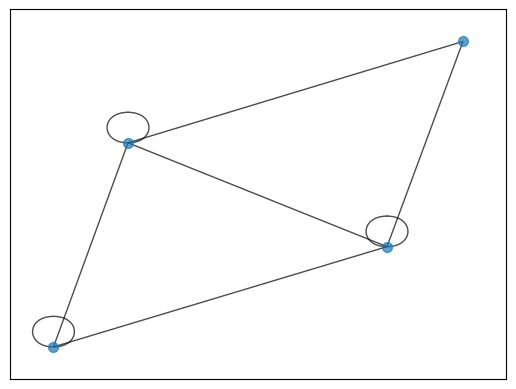

13th motif's Frequency: 7


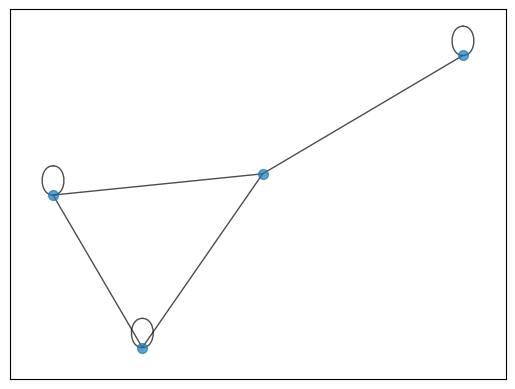

14th motif's Frequency: 5


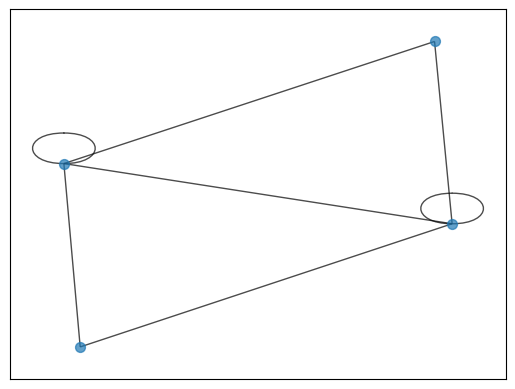

15th motif's Frequency: 3


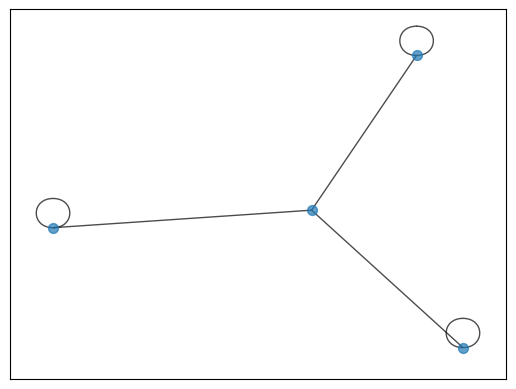

16th motif's Frequency: 3


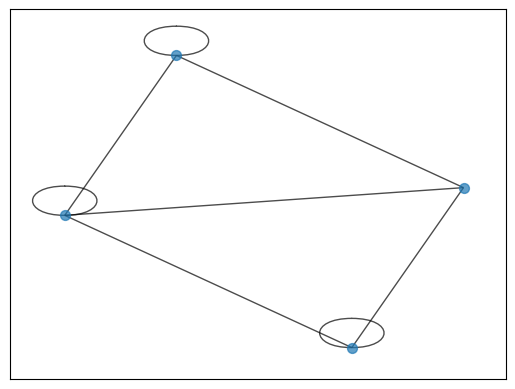

17th motif's Frequency: 3


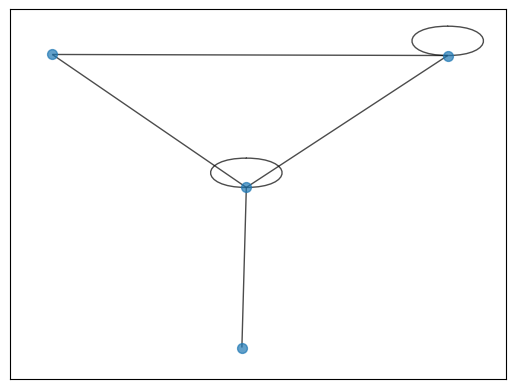

18th motif's Frequency: 3


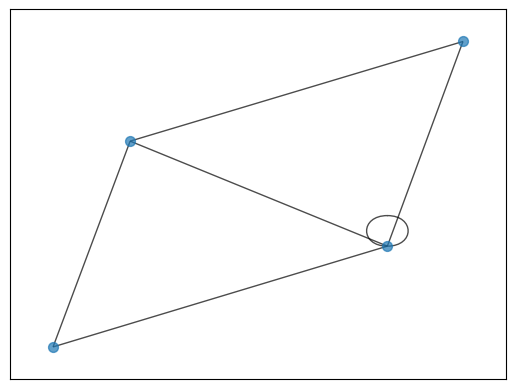

19th motif's Frequency: 2


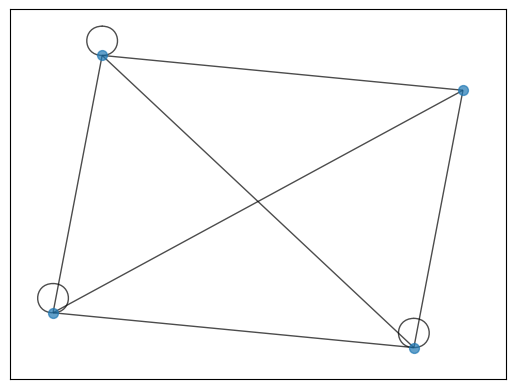

20th motif's Frequency: 2


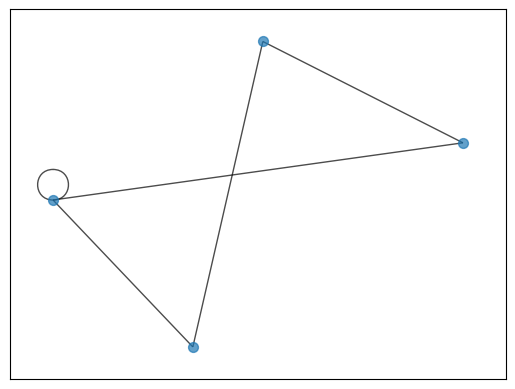

21th motif's Frequency: 2


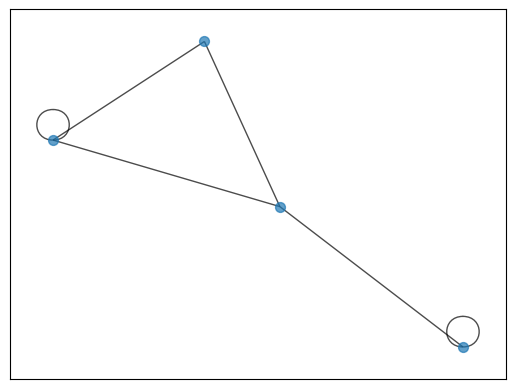

22th motif's Frequency: 1


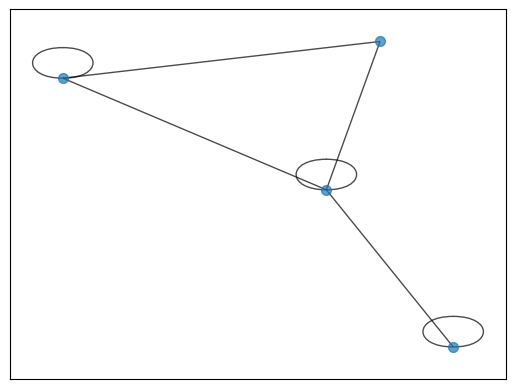

23th motif's Frequency: 1


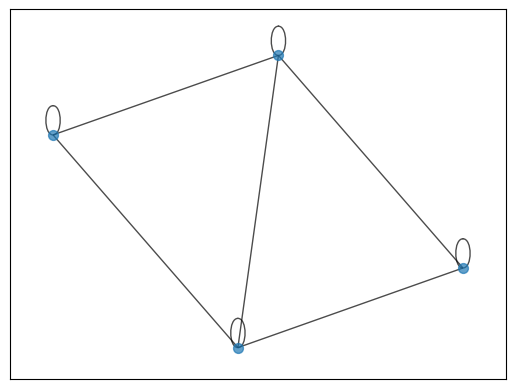

24th motif's Frequency: 1


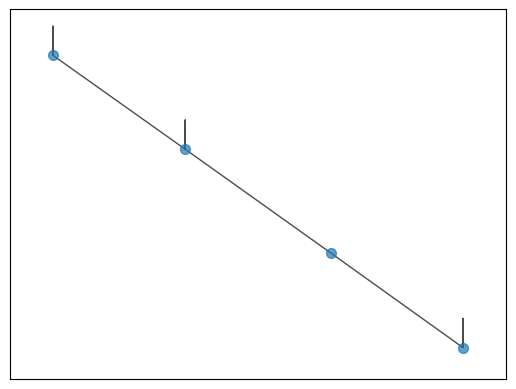

25th motif's Frequency: 1


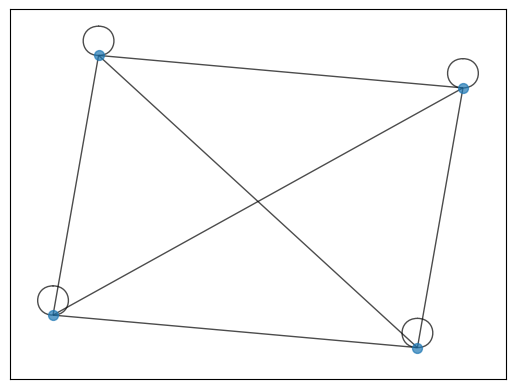

In [ ]:
# motifs found using subgraphs generated by bfs and pruning edges
for i in range(len(motif_freq)):
    print(str(i)+'th motif\'s '+'Frequency:', motif_freq[i][1])
    nx.draw_networkx(motif_freq[i][0], node_size=50,font_size=7, alpha=0.7, with_labels=False)
    plt.show()

In [ ]:
# Now, using the frequently found motifs, build a histogram of occurance in 
# 1.data graph
# 2.barabasi_albert_graph
# 3.erdos_renyi_graph

from tqdm import tqdm

def get_freq_of_motif_from_graph_from_simulation(graph, motif, n_nodes =300, n_simulations=30, from_data=False, er=False, ba=False):
    '''
    Get counts of motifs in graph.

    Random graph method
    er: erdos_renyi_graph
    ba: barabasi_albert_graph

    '''
    # n_nodes_in_data => 10358
    motif_size = len(motif.nodes())
    motifs = np.zeros(shape=(n_simulations,))

    for i in tqdm(range(n_simulations)):
        print
        if from_data:
            subgraph_bfs = rand_connected_component_with_size_n_using_dfs(graph, n=n_nodes, search_depth=5)
            data_motif = find_motifs(motif, subgraph_bfs)
            motifs[i] = len(data_motif)

        if er:
            p = motif_size / 1000.0 + 0.1
            this_er_graph = nx.erdos_renyi_graph(n_nodes, p)
            er_motifs = find_motifs(motif, this_er_graph)
            motifs[i] = len(er_motifs)

        if ba:
            this_ba_graph = nx.barabasi_albert_graph(n_nodes, 5) # param: 1. tot number of nodes avg 2. average degree of each node
            ba_motifs = find_motifs(motif, this_ba_graph)
            motifs[i] = len(ba_motifs)
        
    return motifs

def plot_histogram_and_ztest(n_motif_data, n_motif_ba, n_motif_er):
    plt.hist(n_motif_data)
    plt.title("Number of Motifs in Undirected Glioblastoma Graph")
    plt.show()
    
    plt.hist(n_motif_ba)
    plt.title("Number of Motifs in Undirected Barabasi-Albert Graph")
    plt.show()

    plt.hist(n_motif_er)
    plt.title("Number of Motifs in Undirected Erdos-Renyi Graph")
    plt.show()

    mean_glioblastoma = np.mean(n_motif_data)
    mean_ba = np.mean(n_motif_ba)
    mean_er = np.mean(n_motif_er)

    std_glioblastoma = np.std(n_motif_data)
    std_ba = np.std(n_motif_ba)
    std_er = np.std(n_motif_er)

    Z_ba = (mean_glioblastoma - mean_ba) / std_ba
    Z_er = (mean_glioblastoma - mean_er) / std_er

    p_value_ba = scipy.stats.norm.sf(abs(Z_ba))
    p_value_er = scipy.stats.norm.sf(abs(Z_er))
    
    return p_value_ba, p_value_er

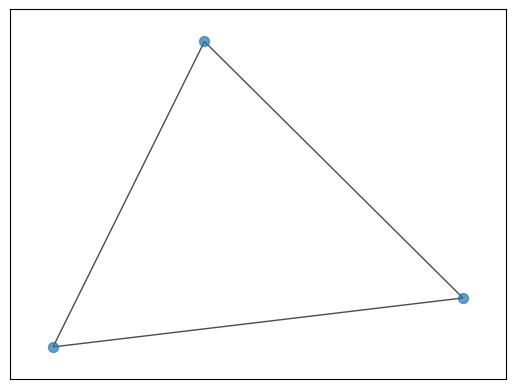

In [ ]:
motif1 = nx.Graph()
motif1.add_edges_from([(1, 2), (2, 3), (3,1)])
nx.draw_networkx(motif1, node_size=50,font_size=7, alpha=0.7, with_labels=False)

In [ ]:
# find first most freuent motif in random graphs and data graph
n_motif1_in_data_graph = get_freq_of_motif_from_graph_from_simulation(g_glio_human_undir, motif1, n_nodes=100, n_simulations=100, from_data=True)
n_motif1_in_er_graph = get_freq_of_motif_from_graph_from_simulation(g_glio_human_undir, motif1, n_nodes=100, n_simulations=100, er=True)
n_motif1_in_ba_graph = get_freq_of_motif_from_graph_from_simulation(g_glio_human_undir, motif1, n_nodes=100, n_simulations=100, ba=True)

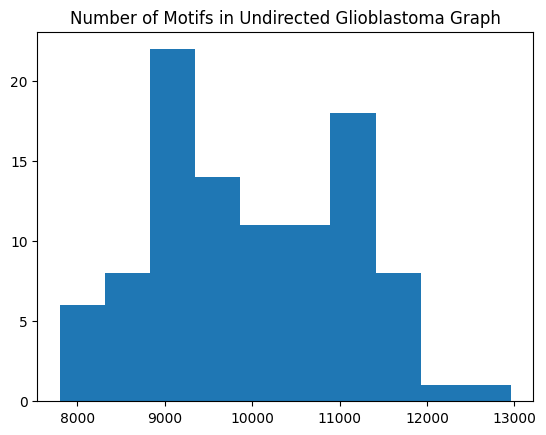

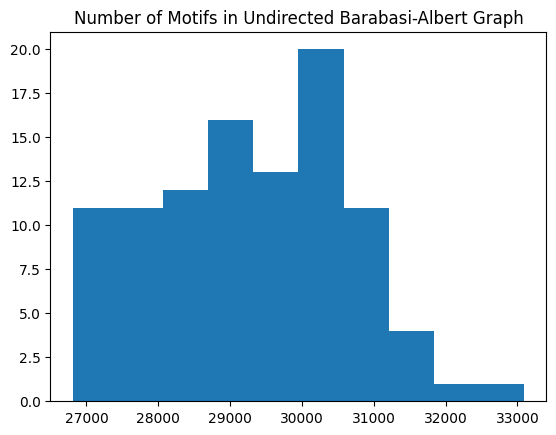

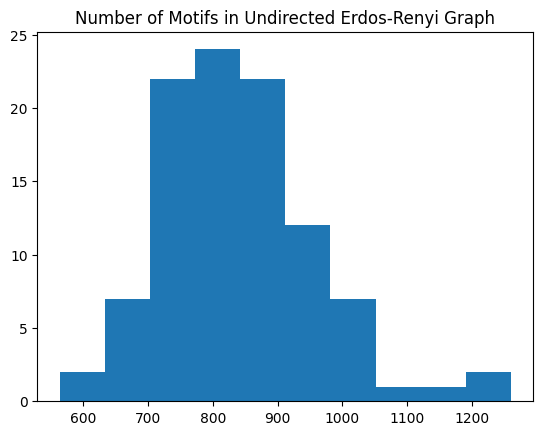

Z_er 72.8161249512333
Z_ba -14.775000357816658
1.0617804007828133e-49
0.0


In [ ]:
p_value_ba, p_value_er = plot_histogram_and_ztest(n_motif1_in_data_graph, n_motif1_in_er_graph, n_motif1_in_ba_graph)
print(p_value_ba)
print(p_value_er)

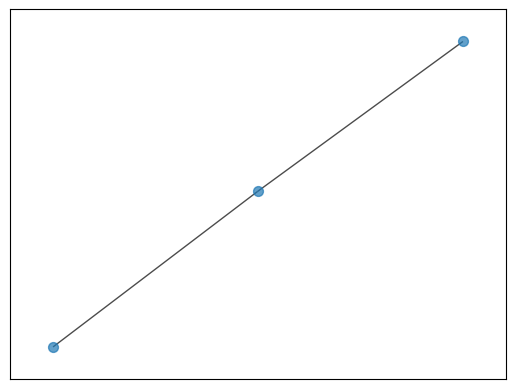

In [ ]:
# find second most freuent motif in random graphs and data graph
motif2 = nx.Graph()
motif2.add_edges_from([(1,2),(2, 3),(3,4)])
nx.draw_networkx(motif2, node_size=50,font_size=7, alpha=0.7, with_labels=False)

In [ ]:
n_motif2_in_data_graph = get_freq_of_motif_from_graph_from_simulation(g_glio_human_undir, motif2, n_simulations=100, from_data=True)
n_motif2_in_er_graph = get_freq_of_motif_from_graph_from_simulation(g_glio_human_undir, motif2, n_simulations=100, er=True)
n_motif2_in_ba_graph = get_freq_of_motif_from_graph_from_simulation(g_glio_human_undir, motif2, n_simulations=100, ba=True)

100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


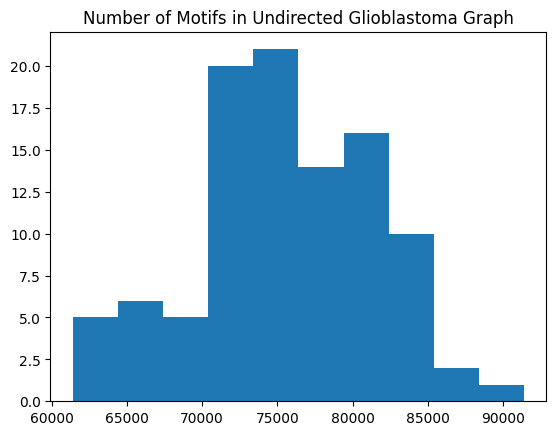

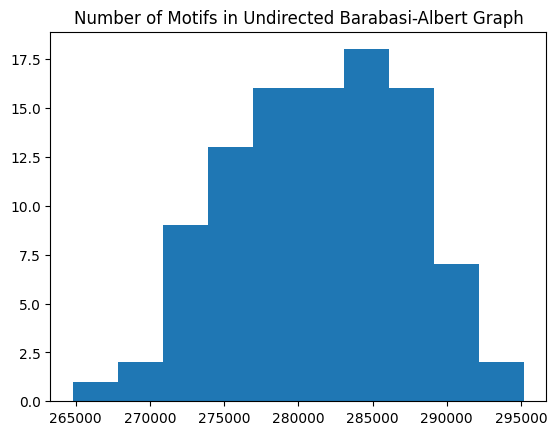

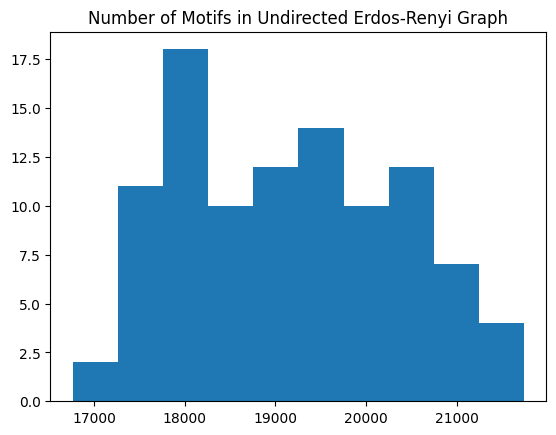

Z_er 46.30306301996699
Z_ba -34.76929278396055


(3.541996898807259e-265, 0.0)

In [ ]:
plot_histogram_and_ztest(n_motif2_in_data_graph, n_motif2_in_er_graph, n_motif2_in_ba_graph)

In [ ]:
# find third most freuent motif in random graphs and data graph
motif3 = nx.Graph()
motif3.add_edges_from([(1,2),(2,3),(3,4),(4,1)])
nx.draw_networkx(motif2, node_size=50, font_size=7, alpha=0.7, with_labels=False)

In [ ]:
n_motif3_in_data_graph = get_freq_of_motif_from_graph_from_simulation(g_glio_human_undir, motif3, n_simulations=100, from_data=True)
n_motif3_in_er_graph = get_freq_of_motif_from_graph_from_simulation(g_glio_human_undir, motif3, n_simulations=100, er=True)
n_motif3_in_ba_graph = get_freq_of_motif_from_graph_from_simulation(g_glio_human_undir, motif3, n_simulations=100, ba=True)

In [ ]:
# Until now, we have identified the structure of the motifs.
# Here, we will use the motif structure to find proteins in our glioblastoma network

def find_motif_of_interest_in_graph(g,motif_of_interest):
    matches = []

    while len(matches)==0:
        #build subgraph
        subgraph_size = 50
        rand_depth_for_bfs = random.randint(1, 5)

        subgraph = rand_connected_component_with_size_n_using_dfs(g, n = subgraph_size, search_depth = rand_depth_for_bfs)
        motif = motif_of_interest
        

        matches = find_motifs(motif, subgraph)
        
    return matches

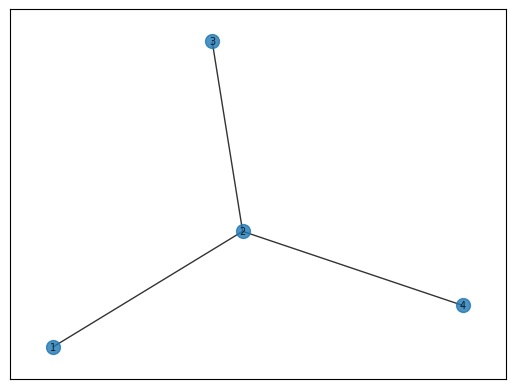

In [ ]:
####
motif_of_interest = nx.Graph()
motif_of_interest.add_edges_from([(1, 2),(2,3), (4,2)])
nx.draw_networkx(motif_of_interest, node_size=100,font_size=7, alpha=0.8)
####

In [ ]:
matches = find_motif_of_interest_in_graph(g_glio_human_undir, motif_of_interest2)

50


In [ ]:
with open('motif_size4_second_shape_10.txt','w') as f:
    for m in matches:
        for i,value in enumerate(m.values()):
            f.write(value+' ')
        f.write('\n')

In [ ]:
 # output of grandiso find_motif function
 searched_subgraph = g_glio_human_undir.subgraph(match_nodes_ls)

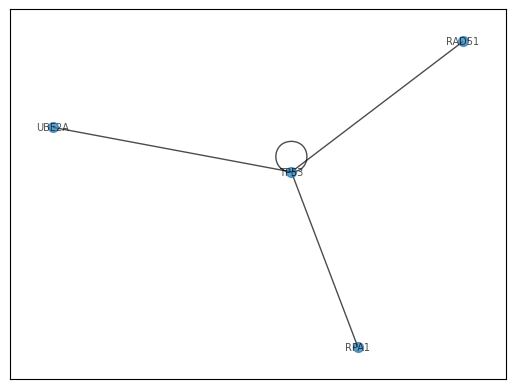

In [ ]:
nx.draw_networkx(searched_subgraph, node_size=50,font_size=7, alpha=0.7, with_labels=True)
plt.show()